In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('D:/Papers/paper_code/new/Data/Processed/Gold_data.csv')

In [3]:
data.head()

,Date,Price,lag_P,lag_O,lag_H,lag_L,lag_V,lag_C,Year,Month,Day,Weekday
0,2014-01-04,0.149943,0.158273,0.152732,0.155756,0.157452,0.027404,0.552305,0.0,0.0,0.100000,0.833333
1,2014-01-06,0.144875,0.171988,0.160382,0.169941,0.168380,0.029368,0.660461,0.0,0.0,0.166667,0.000000
2,2014-01-07,0.139807,0.164133,0.171493,0.172295,0.163886,0.028526,0.456560,0.0,0.0,0.200000,0.166667
3,2014-01-08,0.139016,0.149943,0.147822,0.145744,0.155480,0.000000,0.396277,0.0,0.0,0.233333,0.333333
4,2014-01-09,0.141011,0.144875,0.148483,0.149385,0.148109,0.228021,0.481383,0.0,0.0,0.266667,0.500000


In [4]:
train = data[:-365]
test = data[-365:]
print(train.shape)
print(test.shape)

(1859, 12)
(365, 12)


In [5]:
x_train =  train.drop(columns = {'Date', 'Price'}, axis = 1)
y_train = train.loc[:, ['Price']]

x_test = test.drop(columns = {'Date', 'Price'}, axis = 1)
y_test = test.loc[:, ['Price']]

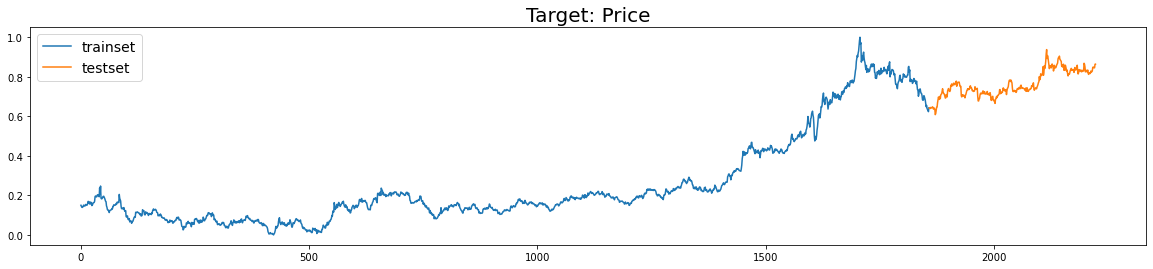

In [6]:
sns.reset_orig()
plt.figure(figsize = (20,4))
plt.title('Target: Price', fontsize = 20)
plt.plot(y_train['Price'], label = 'trainset')
plt.plot(y_test['Price'], label = 'testset')

plt.legend(fontsize = 14)
plt.show()

# LightGBM

In [7]:
import lightgbm as lgb

In [8]:
model_lgb = lgb.LGBMRegressor().fit(x_train, y_train)
pred_lgb = model_lgb.predict(x_test)

In [9]:
def slide_pred(lag_n, pred):
    prediction = list(pred)
    prediction = prediction[lag_n:]
        
    return prediction

In [10]:
pred_lgb = slide_pred(3, pred_lgb)
y_test = y_test[:-3]

In [11]:
r2_lgb = r2_score(pred_lgb, y_test)
mse_lgb = mean_squared_error(pred_lgb, y_test)

print('R2: ', r2_lgb, '  ;  ', 'MSE: ', mse_lgb)

R2:  0.7779202146732851   ;   MSE:  0.0006202808820145849


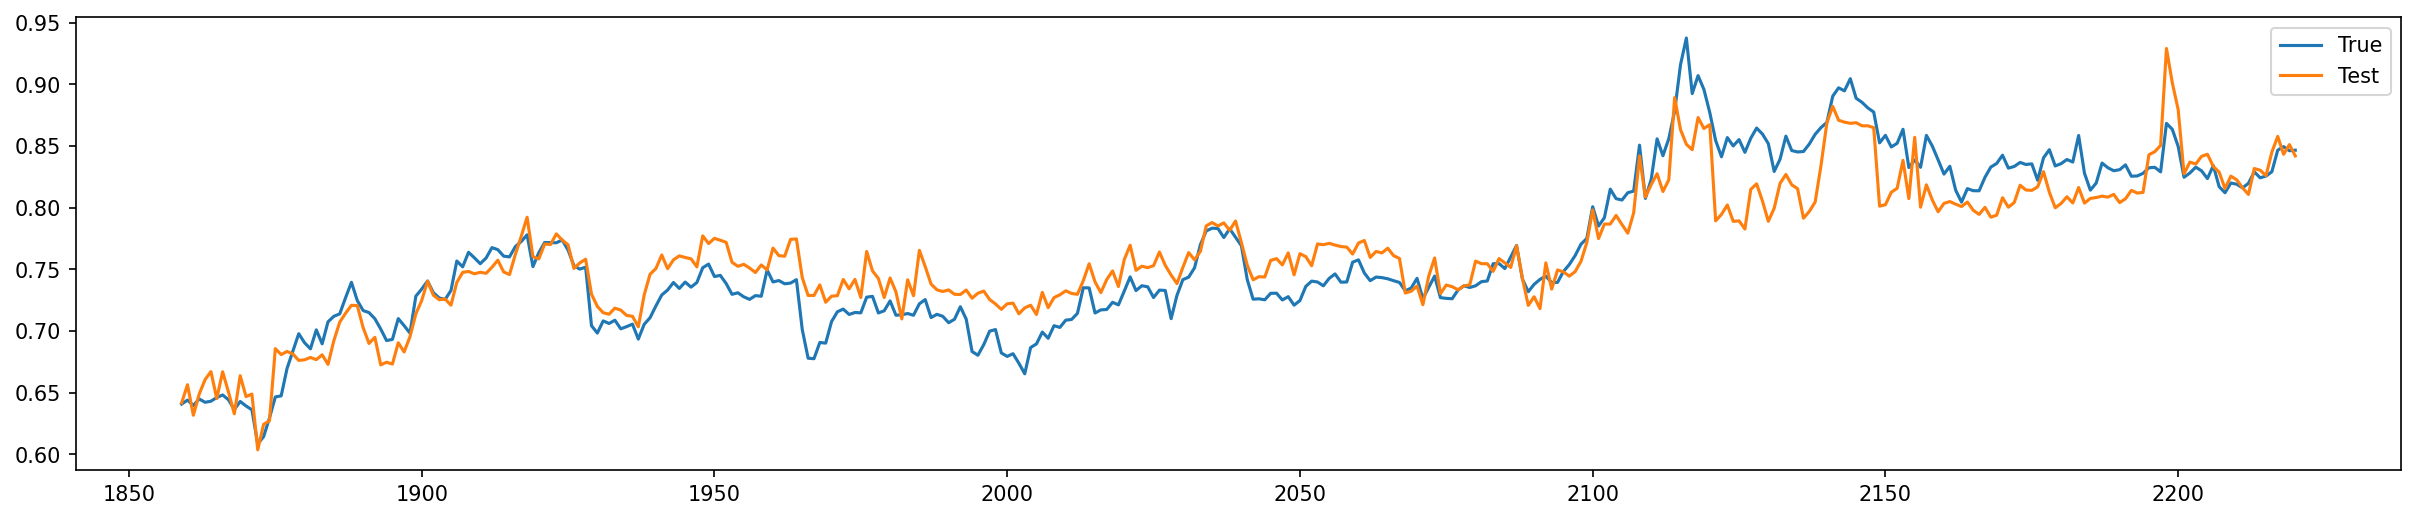

In [12]:
prediction_test = pd.DataFrame(pred_lgb, index=y_test.index)

sns.reset_orig()
plt.figure(figsize = (20,4), dpi=150)

plt.plot(y_test['Price'], label = 'True')
plt.plot(prediction_test, label = 'Test')

plt.legend()
plt.show()

# Interpretation of LightGBM

In [13]:
import ShapTimeBoosting
from ShapTimeBoosting import supertime, ShapleyValues, TimeImportance, TimeHeatmap

In [14]:
# The training set is evenly divided into 11 parts in the time dimension, 
# and the importance of each part is calculated.
Tn= 10
interp_x= x_train
model = model_lgb

ShapTime_lgb = ShapleyValues(model, interp_x, Tn)

In [15]:
ShapTime_lgb

[-0.03979300283488763,
 -0.05855042785835626,
 -0.06409130797674123,
 -0.024898669364478574,
 -0.039331194598904044,
 -0.028788241569083845,
 -0.017779264182960764,
 0.01264357692213267,
 0.08943826689108265,
 0.1716709477449309]

In [16]:
# name these time periods
time_columns =  ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9']

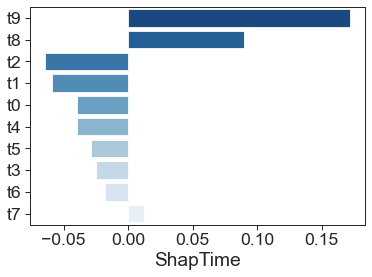

In [17]:
TimeImportance(Tn, ShapTime_lgb, time_columns)

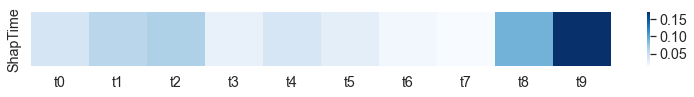

In [18]:
TimeHeatmap(Tn, ShapTime_lgb, time_columns)

# Evaluation of Interpretation

### Feature-Independence

In [19]:
import EvaluationBoosting
from ShapTimeBoosting import FeaIndepenVal, PlotVal

In [20]:
n = 6
Tn = 10
x_train_val = x_train.copy()
y_train = y_train
initial = ShapTime_lgb
model = lgb.LGBMRegressor()

In [21]:
result = FeaIndepenVal(x_train_val, y_train, initial, model, Tn, n, time_columns)

In [22]:
result

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9
0,-0.039793,-0.058550,-0.064091,-0.024899,-0.039331,-0.028788,-0.017779,0.012644,0.089438,0.171671
1,-0.039761,-0.058571,-0.064091,-0.024910,-0.039351,-0.028719,-0.017799,0.012625,0.089424,0.171670
2,-0.039783,-0.058594,-0.064048,-0.024910,-0.039308,-0.028754,-0.017812,0.012611,0.089464,0.171651
3,-0.039835,-0.058536,-0.064060,-0.024916,-0.039341,-0.028806,-0.017806,0.012646,0.089508,0.171664
4,-0.039977,-0.058414,-0.063439,-0.025415,-0.039437,-0.028587,-0.017920,0.012639,0.089273,0.171791
5,-0.039925,-0.058523,-0.063633,-0.025246,-0.039419,-0.028645,-0.017906,0.012730,0.089206,0.171884
6,-0.039869,-0.058634,-0.063623,-0.025121,-0.039523,-0.028534,-0.017876,0.012594,0.089323,0.171794


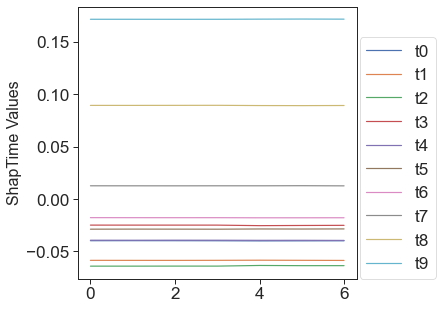

In [23]:
PlotVal(result)

### Sensitivity

In [24]:
situation_0 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  
situation_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 7]  
situation_2 = [0, 1, 2, 3, 4, 5, 6, 7, 7, 7]  

In [25]:
total = [situation_0, situation_1, situation_2]
train_eva = train.drop(columns = 'Date')
df_eva = supertime(10, train_eva)
model_eva = lgb.LGBMRegressor()

In [26]:
import EvaluationBoosting
from EvaluationBoosting import evaluation, R2Plot, MSEPlot

In [27]:
r2_results, mse_results = evaluation(df_eva, x_train, y_train, 'Price', model_eva, total)

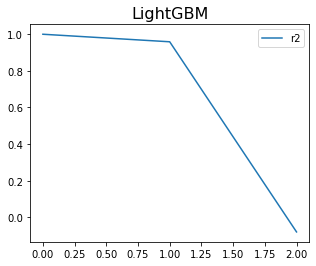

In [28]:
R2Plot(r2_results, 'LightGBM')

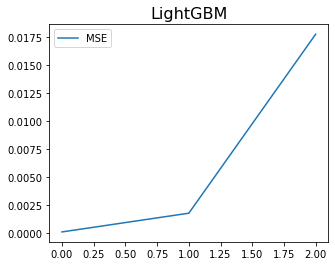

In [29]:
MSEPlot(mse_results, 'LightGBM')

# Improvement

In [30]:
for k in range(Tn):
    exec(f't{k} = supertime(Tn, train)[k]')

In [31]:
check_replist = [t0, t1, t2, t3, t4, t5, t6, t9, t8, t9]

In [32]:
#check 
check = pd.concat(check_replist, axis = 0)
x_check = check.drop(columns = {'Date','Price'}, axis = 1)
y_check = check.loc[:, ['Price']]

model_check = lgb.LGBMRegressor().fit(x_check, y_check)
pred_check = model_check.predict(x_test)

In [33]:
pred_check = slide_pred(3, pred_check)

In [34]:
r2_check = r2_score(pred_check, y_test)
mse_check = mean_squared_error(pred_check, y_test)

print(r2_check, 'Degree of Improvement: {:.2%}'.format((r2_check-r2_lgb)/abs(r2_lgb)))
print(mse_check, 'Degree of Improvement: {:.2%}'.format((mse_lgb-mse_check)/mse_lgb))

0.871585884858406 Degree of Improvement: 12.04%
0.00044415362610143613 Degree of Improvement: 28.39%


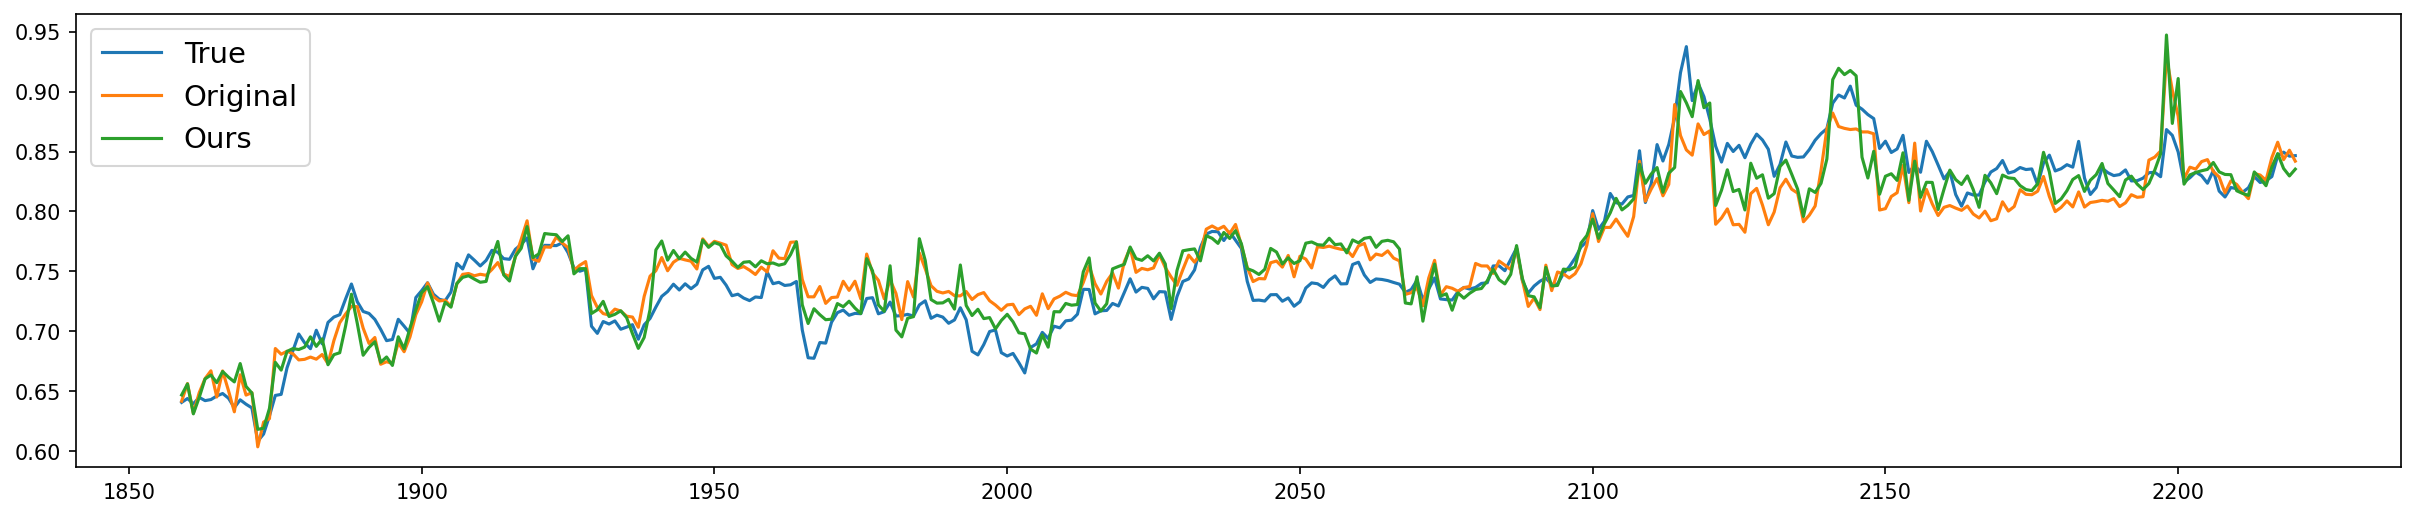

In [35]:
pred_our = pd.DataFrame(pred_check, index=y_test.index)

sns.reset_orig()
plt.figure(figsize = (20,4), dpi=150)

plt.plot(y_test['Price'], label = 'True')
plt.plot(prediction_test, label = 'Original')
plt.plot(pred_our, label = 'Ours')

plt.legend(fontsize = 14)
plt.show()